In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#Se utilizó de guía principalmente:
# https://www.tensorflow.org/tutorials/images/classification
#Y de forma paralela:
# https://keras.io/examples/vision/image_classification_from_scratch/

In [14]:
#Atención, bajar dataset previamente: https://www.kaggle.com/miljan/stanford-dogs-dataset-traintest
#extraerlo, y que la carpeta resultante quede en el mismo directorio que el notebook.
train_dir = 'archive/cropped/train'
test_dir = 'archive/cropped/test'

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14319088487658321997
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8423285637799836134
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2377041021129695917
physical_device_desc: "device: XLA_GPU device"
]


In [16]:
#Test GPU
tf.config.list_physical_devices('GPU')
#Si aca no les aparece una lista vacia, y les corren las cosas sin errores, en particular sin este:
# "CUDA runtime implicit initialization on GPU:0 failed." entonces les anda la GPU.

[]

In [17]:
#Test GPU
tf.test.is_built_with_cuda()

True

In [18]:
#Test GPU
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

False

In [19]:
#Version tensorflow 2.3 como mínimo para tf.keras.preprocessing.image_dataset_from_directory (o instalar tf-nightly a la par)
print(tf.__version__)

2.3.1


In [20]:
#image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
#train_ds = image_generator.flow_from_directory(directory=train_dir,
#                                    seed=1337,
#                                    target_size=image_size,
#                                    batch_size=batch_size)
#test_ds = image_generator.flow_from_directory(directory=test_dir,
#                                    seed=1337,
#                                    target_size=image_size,
#                                    batch_size=batch_size)
#type(train_ds)
#print(train_ds)

In [21]:
image_size = (224, 224) #Todas las imagenes tienen el mismo tamaño y es este.
batch_size = 32 #Hiperpaŕametro, con cuantas imagenes se alimenta a la red a la vez.
                #https://stackoverflow.com/questions/41175401/what-is-a-batch-in-tensorflow

In [22]:
#Genero el dataset de train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=1337,
  image_size=image_size,
  batch_size=batch_size)

Found 12002 files belonging to 120 classes.


In [23]:
type(train_ds)
#tensorflow.python.data.ops.dataset_ops.BatchDataset necesario

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [24]:
print(train_ds)

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [25]:
#Genero el dataset de test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=1337,
  image_size=image_size,
  batch_size=batch_size)

Found 8581 files belonging to 120 classes.


In [26]:
dogs_breeds = train_ds.class_names
print(dogs_breeds)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

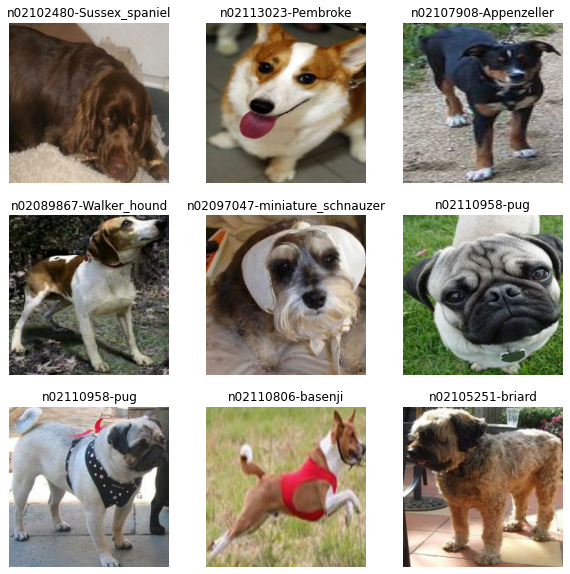

In [27]:
#Visualizamos imagenes del dataset de train
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dogs_breeds[labels[i]])
    plt.axis("off")

In [28]:
#Si bien tenemos muchas imágenes de las distintas razas de perros, es una buena práctica aplicar transformaciones (ejemplo rotaciones) aleatorias realistas,
#para tener más variación, y menos overfit.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

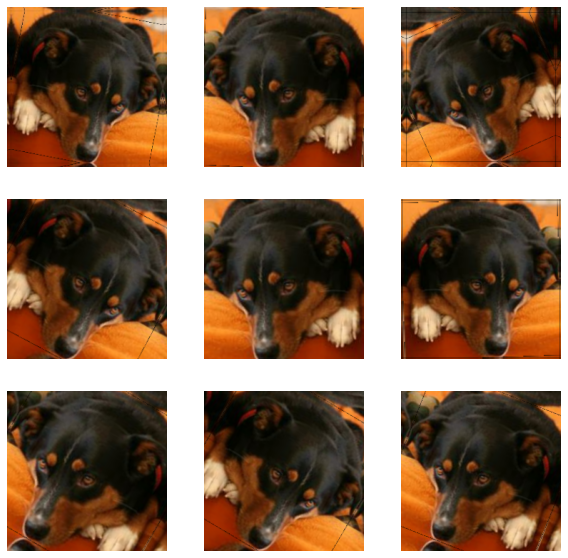

In [29]:
#Agarrando una imagen cualquiera del dataset, y aplicandole distintas transformaciones
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break



(32, 224, 224, 3)
(32,)


In [31]:
# image_batch es un tensor de la forma (32, 224, 224, 3) .
# Se trata de un lote de 32 imágenes de forma 224x224x3 (la última dimensión se refiere a los canales de color RGB).
# label_batch es un tensor de la forma (32,) , estas son etiquetas correspondientes a las 32 imágenes.

In [32]:
#Estandarizar datos
#Una imagen se define en su mayor parte por los valores de sus canales RGB, y estos tienen el rango [0, 255], lo cual no los hace ideales para usar con una red
#neuronal (lo mejor es utilizar valores de entrada pequeños), es por eso que utilizamos una capa de cambio de escala, estandarizando estos de tal forma que queden
#en el rango [0, 1].


In [33]:
#Hay 2 formas de aplicar esta capa:
#1) Realizar un map sobre el set de datos (mejor en los casos donde se va a entrenar utilizando la CPU)
#2) Incluirla como una capa de la red neuronal en la entrada (mejor en los casos donde se va a entrenar con GPU)

#Eligimos la forma 2

In [34]:
#Por cuestiones de performance, para no tener operaciones bloqueantes de E/S, es util utilizar un buffer:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [35]:
#Cuando hay una pequeña cantidad de ejemplos de entrenamiento, el modelo a veces aprende de ruidos o detalles no deseados de ejemplos de entrenamiento,
#hasta el punto de que impacta negativamente el rendimiento del modelo en nuevos ejemplos.
#Este fenómeno se conoce como sobreajuste. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.

#Hay varias formas de luchar contra el sobreajuste en el proceso de formación, 
#en nuestro trabajo práctico decidimos utilizar data_augmentation (aumento de datos) y dropout (abandonar).


In [36]:
#Abandonar
#Dropout es una forma de regularización la cual elimina aleatoriamente (estableciendo la activación en cero) una cantidad de unidades de salida de la capa
#durante el proceso de entrenamiento. La deserción toma un número fraccionario como valor de entrada, en la forma como 0,1, 0,2, 0,4, etc.
#Esto significa eliminar el 10%, 20% o 40% de las unidades de salida al azar de la capa aplicada.

num_classes = 120 #Cantidad de razas de perros en el dataset

#Modelo
model = keras.Sequential([
  data_augmentation, #Aumento datos
  layers.experimental.preprocessing.Rescaling(1./255), #Estandarizo [0,1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #Dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
#Compilamos el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Entrenamos
epochs = 5 #Aca hay que ponerle algun valor alto, podría ser 30... 50 (es un hiperparametro)
#Amí cada epoch me tardaba como 4 minutos porque usaba CPU al 100%.
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

In [ ]:
model.summary()

In [ ]:
img_test_dir = 'archive/cropped/test/n02085620-Chihuahua/n02085620_10074.jpg'

img = keras.preprocessing.image.load_img(
    img_test_dir, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


In [ ]:
print(
    "La imagen pertenece a la raza {} con un {:.2f} % de confianza."
    .format(dogs_breeds[np.argmax(score)], 100 * np.max(score))
)